In [1]:
from tools import analysistools as atools
import nanoparticle
from nanoparticle import Ligand, NanoParticle
import math
from membranesimulation import MembraneSimulation
import numpy as np
from tools import icosatiler
from tools import vectools
from tools import misctools
import k3d
import os
import random
import pickle
from numpy import pi, cos, sin, arccos, arange
import networkx as nx

In [2]:
mag = lambda v : np.sqrt(np.sum([i*i for i in v]))

In [3]:
def goldenSpiral(n,rad):
    num_pts = 60
    indices = arange(0, n, dtype=float) + 0.5
    phi = arccos(1 - 2*indices/n)
    theta = pi * (1 + 5**0.5) * indices
    x, y, z = cos(theta) * sin(phi), sin(theta) * sin(phi), cos(phi)
    sphs = []
    for i in range(len(x)):
        spp = icosatiler.crt2SphPol((x[i],y[i],z[i]))
        spp = (rad,spp[1],spp[2])
        sphs.append(spp)
    return sphs
    

In [4]:
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

In [5]:
def norm(v):
    m = mag(v)
    vN = [float(i)/float(m) for i in v]
    return vN

In [6]:
def crossProd(u,v):
    return ((u[1]*v[2]-u[2]*v[1]),(u[2]*v[0]-u[0]*v[2]),(u[0]*v[1]-u[1]*v[0]))

In [7]:
def makeParticleModelFromPhenome(particle):
    points = []
    plot = k3d.plot()
    i = 1
    maxEps = 0
    for l in particle.ligands:
        if l.eps>maxEps:
            maxEps = l.eps
    for l in particle.ligands:
        if l.eps > 0.0:
            lx = l.rad*np.sin(l.polAng)*np.cos(l.aziAng)
            ly = l.rad*np.sin(l.polAng)*np.sin(l.aziAng)
            lz = l.rad*np.cos(l.polAng)
            lc = '0x' + ('#%02x%02x%02x' % (0, int((l.eps/maxEps)*255.0), 0))[1:]
            
            plot += k3d.points([lx,ly,lz],point_size=1,color=int(lc, 16))
            #plot += k3d.points([lx,ly,lz],point_size=1,color=int(0x00ffff*(l.eps/maxEps)))
            plot += k3d.text(str(i),[lx,ly,lz],color=0xffffff)
            i+=1
    plot += k3d.points([0,0,0],point_size=7,color=0xff0000)
    return plot

In [8]:
def buildCoveredParticle(eps,rad):
    particle = NanoParticle()
    lPos = icosatiler.cover72SpherePolar(rad)
    for v in lPos:
        particle.addLigand(Ligand(eps,1,v[0],v[1],v[2]))
    return particle

In [9]:
def spaceIsOccupied(particle,v):
    for l in particle.ligands:
        d = atools.greatArcDist((l.polAng,l.aziAng),(v[1],v[2]),particle.sig)
        if abs(d) < l.size:
            return True
    return False

In [10]:
def getClosestIcos(particle,v):
    lPos = icosatiler.cover72SpherePolar(particle.sig)
    closest = v
    minD = 1e8
    for l in lPos:
        v1 = icosatiler.sphPol2Crt(l) 
        v2 = icosatiler.sphPol2Crt(v)
        d = np.sum([j*j for j in np.subtract(v1,v2)])
        if abs(d) < minD:
            minD = d
            closest = l
    return closest

In [11]:
# lPos = icosatiler.cover72SpherePolar(4)
# dists = []
# minD = 1e8
# for v in lPos:
#     for l in lPos:
#         if l != v:
#             v1 = icosatiler.sphPol2Crt(l) 
#             v2 = icosatiler.sphPol2Crt(v)
#             d = np.sum([j*j for j in np.subtract(v1,v2)])
#             if abs(d) < minD:
#                 minD = d
#     dists.append(np.sqrt(minD))
# print np.mean(dists)

In [12]:
def addLigand(particle,eps,v,lock=False):
    if lock:
        v = getClosestIcos(particle,v)
    if not spaceIsOccupied(particle,v):
        particle.addLigand(Ligand(eps,1,v[0],v[1],v[2]))
    return particle

In [13]:
def addBelt(particle,eps,rad,n,phi,lock=False):
    step = np.pi*2/float(n)
    for i in range(n):
        v = (rad,step*i,phi)
        particle = addLigand(particle,eps,v,lock)
    return particle

In [14]:
def getArcAngle(dist,rad):
    return dist/rad

In [15]:
def addRing(particle,eps,rad,pos,n,spacing,lock=False):
    step = np.pi*2/float(n)
    if lock:
        origin = getClosestIcos(particle,(rad,pos[0],pos[1]))
        pos = (origin[1],origin[2])
    for i in range(n):
        tD = getArcAngle(spacing,rad)
        tP = step*i
        v = (rad,tD,tP)
        vC = icosatiler.sphPol2Crt(v)
        v1 = icosatiler.sphPol2Crt((rad,0,0))
        v2 = icosatiler.sphPol2Crt((rad,pos[0],pos[1]))
        v3 = crossProd(v1,v2)
        if np.sum([j*j for j in v3])== 0.0:
            #it's parallel!
            particle = addLigand(particle,eps,v,lock)
            continue
        dp = np.dot(v1,v2)
        #the magic sauce :)
        ang = np.arctan2(mag(np.cross(v1,v2)), np.dot(v1,v2))
        rM = vectools.buildERMatrix(v3, ang)
        vC = np.dot(rM,vC)
        v = icosatiler.crt2SphPol(vC)
        particle = addLigand(particle,eps,v,lock)
    return particle

In [16]:
def addPatch(particle,eps,rad,pos,n,spacing,lock=False):
    if lock:
        origin = getClosestIcos(particle,(rad,pos[0],pos[1]))
        pos = (origin[1],origin[2])
    particle = addLigand(particle,eps,(rad,pos[0],pos[1]),lock)
    particle = addRing(particle,eps,rad,pos,n,spacing,lock)
    return particle

In [17]:
def addMesh(particle,eps,rad,n,lock=False):
    mesh = goldenSpiral(n,particle.sig)
    for point in mesh:
        particle = addLigand(particle,eps,point,lock)
    return particle

In [18]:
def addSphericalSpiral(particle,eps,rad,n,a,limit=5*np.pi,lock=False):
    tstep = (2.0*float(limit))/float(n)
    xs = []
    ys = []
    zs = []
    for i in range(int(n)):
        t = -float(limit) + tstep*float(i)
        x = (np.cos(t))/(np.sqrt(1+a*a*t*t))
        y = (np.sin(t))/(np.sqrt(1+a*a*t*t))
        z = (a*t)/(np.sqrt(1+a*a*t*t))
        pol = icosatiler.crt2SphPol((x,y,z))
        particle = addLigand(particle,eps,(rad,pol[1],pol[2]),lock)        
    return particle

In [19]:
def addVivianiCurve(particle,eps,rad,n,a,lock=False):
    tstep = (2.0*float(2.0*np.pi))/float(n)
    xs = []
    ys = []
    zs = []
    for i in range(n):
        t = -float(2.0*np.pi) + tstep*float(i)
        x = a*(1+np.cos(t))
        y = a*(np.sin(t))
        z = 2*a*(np.sin(0.5*t))
        pol = icosatiler.crt2SphPol((x,y,z))
        particle = addLigand(particle,eps,(rad,pol[1],pol[2]),lock)        
    return particle

In [20]:
def addBaseballCurve(particle,eps,rad,n,a,b,lock=False):
    tstep = (float(2.0*np.pi))/float(n)
    xs = []
    ys = []
    zs = []
    for i in range(n):
        t = tstep*float(i)
        x = a*(np.sin(t)) + b*(np.sin(3*t))
        y = a*(np.sin(t)) - b*(np.sin(3*t))
        z = np.sqrt(4*a*b)
        pol = icosatiler.crt2SphPol((x,y,z))
        particle = addLigand(particle,eps,(rad,pol[1],pol[2]),lock)        
    return particle

In [21]:
#makeParticleModelFromPhenome(buildCoveredParticle(6,4))

In [137]:
zoo = {}
minEps = 240
maxEps = 300
epsStep = 60
minNum = 16
maxNum = 17
numStep = 6

In [148]:
for totalEps in xrange(minEps,maxEps,epsStep):
    for i in xrange(minNum,maxNum,numStep):
        p = NanoParticle()
        p = addMesh(p,1,4,i,False)
        eps = float(totalEps)/(float(len(p.ligands)))
        for l in p.ligands:
            l.eps = eps
        zoo["mesh_"+str(len(p.ligands))+"_"+str(totalEps)] = p

print len(p.ligands)

16


In [149]:
sp = 1.5
for totalEps in xrange(minEps,maxEps,epsStep):
    for n in xrange(int(minNum/6.0),int(maxNum/6.0)+1,int(numStep/6.0)):
        p = NanoParticle()
        for i in range(4):
            p = addPatch(p,1,4,(float(i)*(np.pi*0.5),0),n,sp)
        for i in range(2):
            p = addPatch(p,1,4,((np.pi*0.5),float(i)*(np.pi)+0.5*np.pi),n,sp)
        eps = float(totalEps)/(float(len(p.ligands)))
        for l in p.ligands:
            l.eps = eps
        zoo["cube_"+str(len(p.ligands))+"_"+str(totalEps)] = p

print len(p.ligands)

18


In [150]:
sp = 2.5
for totalEps in xrange(minEps,maxEps,epsStep):
    for n in range(int(minNum/6.0),int(maxNum/6.0)+1,int(numStep/6.0)):
        p = NanoParticle()
        for i in range(4):
            p = addRing(p,1,4,(float(i)*(np.pi*0.5),0),n,sp)
        for i in range(2):
            p = addRing(p,1,4,((np.pi*0.5),float(i)*(np.pi)+0.5*np.pi),n,sp)
        eps = float(totalEps)/(float(len(p.ligands)))
        for l in p.ligands:
            l.eps = eps
        zoo["ring_"+str(len(p.ligands))+"_"+str(totalEps)] = p
        
print len(p.ligands)

12


In [151]:
for totalEps in xrange(minEps,maxEps,epsStep):
    for n in xrange(int(minNum/2.0+2.0),int(maxNum/2.0+2.0)+1,int(numStep/2.0)):
        p = NanoParticle()
        p = addBelt(p,1,4,n,0)
        p = addBelt(p,1,4,n,np.pi*0.5)
        eps = float(totalEps)/(float(len(p.ligands)))
        for l in p.ligands:
            l.eps = eps
        zoo["cross_"+str(len(p.ligands))+"_"+str(totalEps)] = p
        
print len(p.ligands)

18


In [152]:
for totalEps in xrange(minEps,maxEps,epsStep):
    for n in xrange(int(minNum/3.0),int(maxNum/3.0)+1,4):
        p = NanoParticle()
        p = addBelt(p,1,4,n,0)
        p = addBelt(p,1,4,n,np.pi*0.5)
        p = addRing(p,1,4,(0,0),n,np.pi*2)
        eps = float(totalEps)/(float(len(p.ligands)))
        for l in p.ligands:
            l.eps = eps
        zoo["octet_"+str(len(p.ligands))+"_"+str(totalEps)] = p
        
print len(p.ligands)

14


In [153]:
for totalEps in xrange(minEps,maxEps,epsStep):
    for n in xrange(minNum,maxNum,numStep):
        p = NanoParticle()
        p = addSphericalSpiral(p,10,4,n,0.3,3*np.pi)
        eps = float(totalEps)/(float(len(p.ligands)))
        for l in p.ligands:
            l.eps = eps
        zoo["spiral_"+str(len(p.ligands))+"_"+str(totalEps)] = p
        
print len(p.ligands)

16


In [154]:
for totalEps in xrange(minEps,maxEps,epsStep):
    for n in xrange(minNum,maxNum,numStep):
        p = NanoParticle()
        p = addVivianiCurve(p,10,4,n,4)
        eps = float(totalEps)/(float(len(p.ligands)))
        for l in p.ligands:
            l.eps = eps
        zoo["viviani_"+str(len(p.ligands))+"_"+str(totalEps)] = p
        
print len(p.ligands)

15


In [155]:
print len(zoo)

7


In [156]:
makeParticleModelFromPhenome(p)

Plot(antialias=True, background_color=16777215, grid=[-1, -1, -1, 1, 1, 1], height=512, object_ids=[120900237904, 120899674960, 120900070416, 120898611536, 120899430352, 120899674832, 120900070608, 120900238032, 120900068240, 120900070288, 120900235344, 120900236048, 120900069520, 120900205968, 120900069904, 120900238416, 120900235408, 120900235472, 120900237968, 120900236816, 120900236368, 120900236432, 120900238480, 120900238864, 120900237328, 120900235536, 120900237584, 120900235728, 120900235664, 120900238352, 120900070544])

In [157]:
for k, v in zoo.iteritems():
    print k

spiral_16_240
octet_14_240
viviani_15_240
cross_18_240
ring_12_240
cube_18_240
mesh_16_240


In [158]:
with open('zoo.pickle', 'wb') as handle:
    pickle.dump(zoo, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Networks

In [49]:
nets = []
for k, v in zoo.iteritems():
    nets.append((k,atools.pruneNetwork(atools.buildLigandNetwork(v.ligands),0.5)))
    

In [50]:
netFilePath = 'db/zoo-nets2.csv'

with open(netFilePath, 'w') as netFile:

    netWriter = atools.UnicodeWriter(netFile)

    netWriter.writerows([[
            "Name",
            "Density",
            "Max Diameter",
            "Mean Diameter",
            "Min Radius",
            "Average Radius",
            "Subgraph Number",
            "Estrada Coefficient"
            ]])

    for n in nets:
        pN = n[1]
        density = nx.density(pN)
        graphs = list(nx.connected_component_subgraphs(pN))
        dS = []
        rS = []
        for g in graphs:
            d = nx.diameter(g)
            r = nx.radius(g)
            dS.append(d)
            rS.append(r)
        maxDiameter = np.max(dS)
        avgDiameter = np.mean(dS)
        minRadius = np.min(rS)
        avgRadius = np.mean(rS)
        subgraphs = len(graphs)
        estrada = nx.estrada_index(pN)

        netWriter.writerows([[
            str(n[0]),
            str(density),
            str(maxDiameter),
            str(avgDiameter),
            str(minRadius),
            str(avgRadius),
            str(subgraphs),
            str(estrada)
        ]])

# Analysis

In [430]:
import csv
import pandas as pd
%matplotlib inline
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [356]:
def makeHeatmap(array,label,annot=False):
    df = pd.DataFrame.from_dict(np.array(array).T)
    df.columns = ['Ligand Number','Affinity (kT)',label]
    df['Z_value'] = pd.to_numeric(df[label])
    pf = df.pivot('Affinity (kT)','Ligand Number',label)
    return sns.heatmap(pf, cmap="cool",annot=False, fmt='.1f')

In [403]:
typeData = {}
netData = {}

with open('db/zoo.csv', 'rb') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in spamreader:
        rowsplit = ', '.join(row).split(',')
        ftype = rowsplit[0].split('_')
        ptype = ftype[0]
        nlig = int(ftype[1])
        teps = int(ftype[2])
        if not ptype in typeData:
            typeData[ptype] = {}
        if not nlig in typeData[ptype]:
            typeData[ptype][nlig] = {}
        if not teps in typeData[ptype][nlig]:
            typeData[ptype][nlig][teps] = [float(i) for i in rowsplit[1:]]

with open('db/zoo-nets.csv', 'rb') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    rowNum=0
    measures = []
    for row in spamreader:
        if rowNum>0:
            rowsplit = ', '.join(row).split(',')
            ftype = rowsplit[0].split('_')
            ptype = ftype[0]
            nlig = int(ftype[1])
            teps = int(ftype[2])
            if not ptype in netData:
                netData[ptype] = {}
            if not nlig in netData[ptype]:
                netData[ptype][nlig] = {}
            if not teps in netData[ptype][nlig]:
                netData[ptype][nlig][teps] = {}
            colNum = 1
            for m in measures[1:]:
                if not m in netData[ptype][nlig][teps]:
                    netData[ptype][nlig][teps][m] = rowsplit[colNum]
                colNum +=1
            if not 'Fitness' in netData[ptype][nlig][teps]:
                netData[ptype][nlig][teps]['Fitness'] = typeData[ptype][nlig][teps][2]
            if not 'BudTime' in netData[ptype][nlig][teps]:
                netData[ptype][nlig][teps]['BudTime'] = typeData[ptype][nlig][teps][4]
        else:
            measures = ''.join(row).split(',')
        rowNum+=1

fitnesses = {}
budtimes = {}
ptypes = []

for t,v in typeData.iteritems():
    ptypes.append(t)
    if not t in fitnesses:
        fitnesses[t] = []
    if not t in budtimes:
        budtimes[t] = []           
    for nl,v in typeData[t].iteritems():
        for eps,v2 in v.iteritems():
            fitnesses[t].append([nl,eps,v2[2]])
            budtimes[t].append([nl,eps,v2[4]])
        

In [260]:
def splitToXYZ(array):
    x = np.array(array)[:, 0]
    y = np.array(array)[:, 1]
    z = np.array(array)[:, 2]
    return [x,y,z]

In [274]:
def splitToXYZwithNaNs(array):
    x = np.array(array)[:, 0]
    y = np.array(array)[:, 1]
    z = np.array(array)[:, 2]
    for i in range(len(z)):
        if z[i] < 0:
            z[i] = np.NaN
    return [x,y,z]

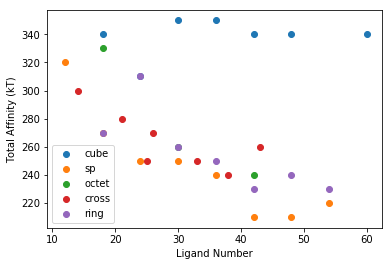

In [365]:
typeScatter = []
for t in ptypes:
    narr = np.array(budtimes[t])
    steps = list(set(narr[:,0]))
    clumps = [narr[np.where(narr[:,0] == s)] for s in steps]
    maxNonZeroes = []
    for c in clumps:
        maxNonZero = -1
        bVal = [c[0]]
        for v in c:
            if v[-1] > 0 and v[-1] > maxNonZero:
                maxNonZero = v[-1]
                bVal = v[0:2]
        if maxNonZero != -1:
            maxNonZeroes.append(list(bVal))
    typeScatter.append(maxNonZeroes)

for t in range(len(typeScatter)):
    x = np.array(typeScatter[t])[:, 0]
    y = np.array(typeScatter[t])[:, 1]
    plt.scatter(x, y,label=ptypes[t])
plt.legend()
plt.xlabel('Ligand Number')
plt.ylabel('Total Affinity (kT)')
plt.show()

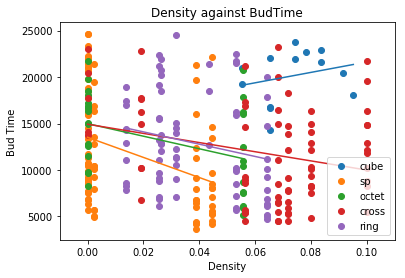

not enough data available in cube


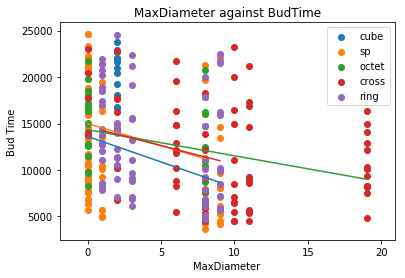

not enough data available in cube


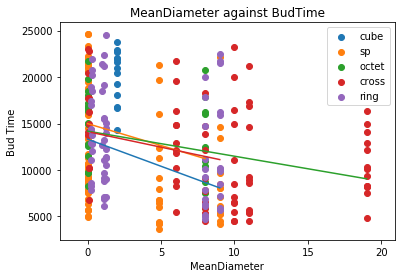

not enough data available in cube


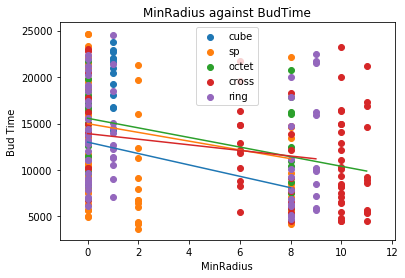

not enough data available in cube


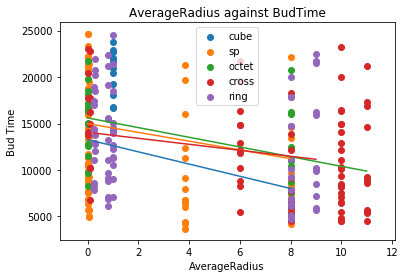

not enough data available in cube


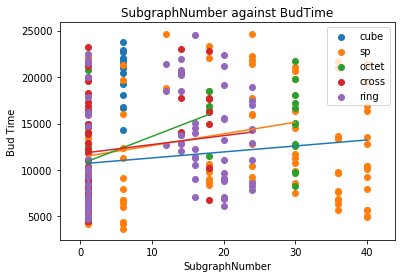

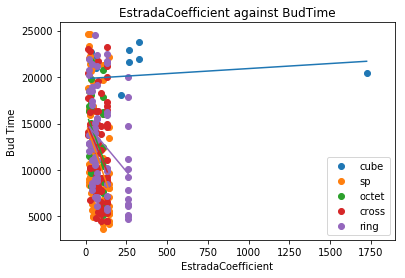

In [437]:
for m in measures[1:]:
    minX = 1e8
    maxX = -1e8
    for t in ptypes:
        x = []
        y = []
        for nlig,v1 in netData[t].iteritems():
            for eps,v2 in v1.iteritems():
                if v2['BudTime']>0:
                    x.append(float(v2[m]))
                    y.append(v2['BudTime'])
        plt.scatter(x, y,label=t,alpha=1.0)
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            try:
                plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
            except np.RankWarning:
                print "not enough data available in " + t
                
        
        if min(x) < minX:
            minX = min(x)
        if max(x) > maxX:
            maxX = max(x)
    plt.legend()
    plt.title(m + " against BudTime")
    plt.xlabel(m)
    
    rang = maxX-minX
    plt.xlim(minX-0.1*rang, maxX+0.1*rang)
    plt.ylabel('Bud Time')
    plt.show()

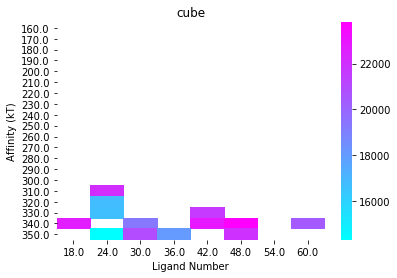

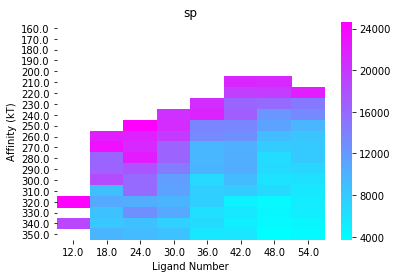

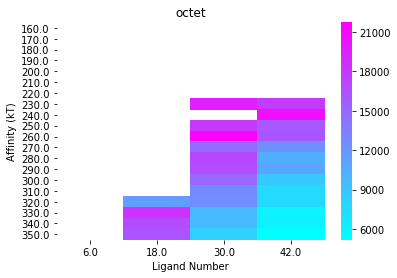

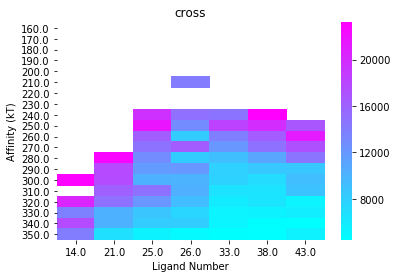

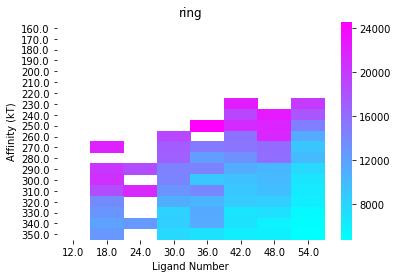

In [357]:
for t in ptypes:
    makeHeatmap(splitToXYZwithNaNs(budtimes[t]),"Budtimes",annot=True)
    plt.title(t)
    plt.show()